# Homework 9 - Building GPT Model from Scratch

In this assignment, you will build a simplified version of a GPT model from scratch, implementing key components step-by-step. This assignment is inspired by the following papers and YouTube video:
- [Attention is All You Need](https://arxiv.org/pdf/1706.03762)
- [GPT-1: Improving Language Understanding by Generative Pre-Training](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf)
- [GPT-2: Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
- [GPT-3: Language Models are Few-Shot Learners](https://arxiv.org/pdf/2005.14165)
- [Let’s build GPT: from scratch, in code, spelled out by Andrej Karpathy](https://youtu.be/kCc8FmEb1nY?si=wVpARi1LfM_S9rcr)

The main tasks are summarized below:
- **Prepare Data**: Download and load a simple text dataset, build a character-level vocabulary and tokenized sequences, and create data loaders.
- **Define the GPT Model**: Implement the core model components:
  - Token Embeddings
  - Positional Encoding [10/10]
  - Single-Head Self-Attention [20/20]
  - Multi-Head Self-Attention [10/10]
  - Feed-Forward Network [10/10]
  - Transformer Decoder Layer [10/10]
  - Stacking Multiple Decoder Layers [10/10]
  - Complete GPT Model [30/30]
- **Train the Model**: Train the model to learn a language model from text.
- **Evaluate the Model**: Assess model quality by generating text.

## 0 - Useful Libraries
First, let’s import all the necessary libraries for this assignment. The primary libraries we’ll use are:
- [PyTorch](https://pytorch.org/): For building and training neural network models.
- [Matplotlib](https://matplotlib.org/stable/): For plotting results.
- [math](https://docs.python.org/3/library/math.html): For mathematical functions used in the positional encoding and scaling.

In [ ]:
import torch
import matplotlib.pyplot as plt
import math

## 1 - Preparting Data

We first download and read a toy text dataset, [TinyShakespeare](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt), which comprises approximately 40,000 lines from various works by William Shakespeare.

In [ ]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-11-14 20:54:32--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2024-11-14 20:54:33 (25.5 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [ ]:
len(text)

1115394

### 1-1 Encoding Text

Next, we extract the unique characters (`chars`) from the `text` to build a character-level vocabulary. The number of distinct characters will define our `vocab_size`, which represents the total number of possible tokens in our character-based language model.

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("vocab: ", chars)
print("vocab_size:", vocab_size)

vocab:  ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocab_size: 65


A vocabulary maps each unique character to a distinct integer, which allows us to work with characters as numerical inputs. We’ll implement the vocabulary using a dictionary called `s2i` (string-to-integer). For convenience, we’ll also define a reverse dictionary, `i2s` (integer-to-string), to map integers back to their respective characters.

Additionally, we’ll define two functions, `encode` and `decode`, to freely convert between sequences of characters and sequences of integers. The `encode` function converts a string of characters to their corresponding integer indices, while `decode` converts a sequence of integers back to characters.

In [ ]:
s2i = {ch:i for i,ch in enumerate(chars)}
i2s = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [s2i[c] for c in s]
decode = lambda l: ''.join([i2s[i] for i in l])

print(encode("Hello World!"))
print(decode(encode("Hello World!")))

[20, 43, 50, 50, 53, 1, 35, 53, 56, 50, 42, 2]
Hello World!


Next, we use the `encode` function to convert the `text` input into `encoded_text`, where each character (or token) is represented by an integer. This encoded form allows us to work with the text in a format suitable for model training.

In [ ]:
encoded_text = encode(text)
print(encoded_text[:50])

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56, 53, 41, 43, 43, 42, 1, 39, 52, 63, 1, 44, 59, 56, 58, 46, 43, 56, 6, 1, 46, 43, 39, 56]


### 1-2 Prepare Dataset and Data Loader

Now that we have `encoded_text`, we can prepare the dataset and data loader for training.

We will build the training and validation datasets and data loaders to contain `(src, tgt)` pairs, where `src` is the source sequence and `tgt` is the target sequence that the model will learn to predict.

For GPT, as a language model, it continuously predicts the next token by modeling the conditional probability:
$$
p(x_t|x_1, \cdots, x_{t-1}) = f_{\theta}(x_1, \cdots, x_{t-1})
$$
where $f_{\theta}$ denotes the model.

This means that, given a *source* sequence $(x_1,\cdots, x_t)$, the model can continuously make predictions for the sequence $(x_2, \cdots, x_t, x_{t+1})$, which is treated as the *target* sequence. By using the ground-truth sequence as a guide during training to predict the next token, this approach is known as **teacher forcing**.

In [ ]:
context_len = 100
source_sequences = [encoded_text[i:i + context_len] for i in range(len(encoded_text)-context_len)]
target_sequences = [encoded_text[i+1:i+1+context_len] for i in range(len(encoded_text)-context_len)]

In [ ]:
src, tgt = source_sequences[0], target_sequences[0]
for t in range(10):
    context = src[:t+1]
    target = tgt[t]
    print(f"when input is {context} or '{decode(context)}' the target: {target} or {decode([target])}")

when input is [18] or 'F' the target: 47 or i
when input is [18, 47] or 'Fi' the target: 56 or r
when input is [18, 47, 56] or 'Fir' the target: 57 or s
when input is [18, 47, 56, 57] or 'Firs' the target: 58 or t
when input is [18, 47, 56, 57, 58] or 'First' the target: 1 or  
when input is [18, 47, 56, 57, 58, 1] or 'First ' the target: 15 or C
when input is [18, 47, 56, 57, 58, 1, 15] or 'First C' the target: 47 or i
when input is [18, 47, 56, 57, 58, 1, 15, 47] or 'First Ci' the target: 58 or t
when input is [18, 47, 56, 57, 58, 1, 15, 47, 58] or 'First Cit' the target: 47 or i
when input is [18, 47, 56, 57, 58, 1, 15, 47, 58, 47] or 'First Citi' the target: 64 or z


In [ ]:
import torch
source_tensor = torch.tensor(source_sequences)
target_tensor = torch.tensor(target_sequences)

Next, to build our *customized* dataset, we’ll use PyTorch’s `Dataset` class to define a custom class called `TextDataset`. This class will handle input sequences (`src_seqs`) and target sequences (`tgt_seqs`), allowing us to efficiently load the data for training.

Specifically:
1. **Initialization (`__init__`)**: The class will take `src_seqs` and `tgt_seqs` as inputs and store them as instance attributes.
2. **Length (`__len__`)**: Implement the `__len__()` method to return the total number of samples, based on the length of `src_seqs` or `tgt_seqs`.
3. **Get Item (`__getitem__`)**: Implement the `__getitem__()` method to take an index `idx` and return the corresponding input-target pair from `src_seqs` and `tgt_seqs`.

**Exercise [1/1]**: Implement the class `TextDataset`.

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, src_seqs, tgt_seqs):
        self.src_seqs = src_seqs
        self.tgt_seqs = tgt_seqs

    def __len__(self):
        return len(self.src_seqs)

    def __getitem__(self, idx):
        return self.src_seqs[idx], self.tgt_seqs[idx]

Next, we split the dataset into training and validation sets to allow for proper model evaluation. We’ll then convert these datasets into data loaders, specifying a `batch_size` to enable mini-batch processing during training.

This setup will help us efficiently feed the model with data in batches, improving training speed and stability.

In [ ]:
dataset = TextDataset(source_tensor, target_tensor)
n = int(0.9*len(dataset))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n, len(dataset)-n])

batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
batch = next(iter(train_dataloader))
src, tgt = batch  # TensorDataset returns tuples, so no need for ['source'] or ['target']
print(src.shape) # (batch_size, context_len)
print(tgt.shape)
print(src)
print(tgt)

torch.Size([64, 100])
torch.Size([64, 100])
tensor([[54, 43, 39,  ..., 58, 46, 43],
        [61, 46, 39,  ..., 47, 50, 58],
        [42,  1, 47,  ..., 52, 45,  1],
        ...,
        [ 5, 50, 50,  ..., 19, 53,  6],
        [ 1, 52, 53,  ..., 43,  1, 44],
        [45,  1, 58,  ...,  1, 61, 47]])
tensor([[43, 39, 56,  ..., 46, 43, 56],
        [46, 39, 58,  ..., 50, 58,  1],
        [ 1, 47, 58,  ..., 45,  1, 58],
        ...,
        [50, 50,  1,  ..., 53,  6,  1],
        [52, 53, 58,  ...,  1, 44, 53],
        [ 1, 58, 46,  ..., 61, 47, 50]])


## 2 - Define the GPT Model
The implementation primarily follows the structure described in the [Transformer paper](https://arxiv.org/pdf/1706.03762), with modifications specific to GPT's decoder-only architecture.

### 2.1 - Word Embeddings
Rather than loading a pre-trained embedding matrix, we will jointly learn the word embeddings along with the GPT model. Specifically, the embedding matrix is a linear transformation with shape `(vocab_size, d_model)`, where `d_model` is the embedding dimension.

In the Transformer architecture, each layer has a consistent input and output dimension, meaning the input and output dimensions for all layers are `d_model`. This consistency applies to various layers, including the embedding layer, positional encoding layer, attention layers, and the feed-forward (FFC) layer.

In [ ]:
d_model = 128
word_embdedding = nn.Embedding(vocab_size, d_model)
src_word_embdedding = word_embdedding(src)
print(src_word_embdedding.shape) # (batch_size, context_len, d_model)
print(src_word_embdedding[0,:5,:10])

torch.Size([64, 100, 128])
tensor([[-1.0554e+00,  1.6954e+00, -2.4202e-01, -4.9427e-01, -1.0299e+00,
          6.5240e-01,  6.9196e-01,  7.8295e-01,  1.3119e+00, -1.5066e+00],
        [ 3.9102e-01, -2.7864e-01,  9.8735e-01, -1.2710e+00,  2.3319e-01,
         -1.4863e+00, -1.1901e+00,  1.3984e+00,  2.9241e-01,  2.3703e+00],
        [ 2.3685e+00, -1.2216e+00,  3.9153e-01,  1.5304e+00, -1.0921e+00,
         -8.5030e-01,  2.9027e-01,  3.0096e-01, -1.5025e+00,  1.0787e+00],
        [ 7.3105e-01, -1.1671e+00,  6.2290e-02, -2.4366e+00,  1.8173e-01,
         -5.8675e-01,  7.5963e-04,  2.5695e-01, -4.7041e-01,  6.3607e-01],
        [-1.3759e+00, -7.8917e-01, -1.6203e+00, -4.5433e-01, -1.7818e+00,
          3.3061e-01, -3.7878e-01,  1.7102e+00,  1.4141e+00, -1.8137e+00]],
       grad_fn=<SliceBackward0>)


### 2.2 - Positional Encoding [1/1]

As discussed in the lectures, the attention mechanism does **not** inherently consider *sequence order*. To enable a language model to use attention while preserving positional information, the Transformer model introduces **positional encoding**, which embeds positional information into the representation space.

The positional encoding used in Transformers is defined as:
$$
\begin{align}
&PE_{pos,2i} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)\\
&PE_{pos,2i+1} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)
\end{align}
$$

In our `PositionalEncoding` class, we will create a lookup table `pe` with shape `(num_range, d_model)`, where `num_range` is greater than `context_len`. Here, `pe` is a matrix in which each row corresponds to the positional encoding for that row’s index. For instance, `pe[0]` is the encoding for position `0`, `pe[1]` is for position `1`, and so on.

**Exercise [1/1]**: Implement the `forward()` method in the `PositionalEncoding` class. The `forward` method takes an embedded sequence `x` with shape `(batch_size, context_len, d_model)`, adds the corresponding positional encoding from `pe`, and returns the result.

**Note**: We store `pe` as a *registered buffer* so that it can be used during forward passes without being a learnable parameter.

In [ ]:
from torch import nn
import torch
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, num_range=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.num_range = num_range
        pe = torch.zeros(num_range, d_model)
        position = torch.arange(0, num_range).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension
        # Register `pe` as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch_size, sequence_length, d_model)
        # pe: (1, context_len, d_model)
        ### Code HERE ### (~ 1 line)

        ### Code HERE ###
        return x

In [ ]:
pos_encoding = PositionalEncoding(d_model=d_model, num_range=context_len)
print(pos_encoding.pe.shape)
# print(pos_encoding.pe)

# Apply positional encoding to the word embeddings
src_embedded = pos_encoding(src_word_embdedding)
print(src_embedded.shape)
print(src_embedded[0,:5,:10])

torch.Size([1, 100, 128])
torch.Size([64, 100, 128])
tensor([[-1.0554,  2.6954, -0.2420,  0.5057, -1.0299,  1.6524,  0.6920,  1.7829,
          1.3119, -0.5066],
        [ 1.2325,  0.2617,  1.7491, -0.6231,  0.9148, -0.7545, -0.5854,  2.1948,
          0.8256,  3.2163],
        [ 3.2778, -1.6378,  1.3786,  1.3699, -0.0946, -0.7794,  1.2535,  0.5697,
         -0.6004,  1.5102],
        [ 0.8722, -2.1571,  0.5796, -3.2924,  0.9600, -1.2147,  0.9304, -0.1115,
          0.5228,  0.5201],
        [-2.1327, -1.4428, -1.9370, -1.4029, -1.6402, -0.6593,  0.1388,  0.8545,
          2.1926, -2.4414]], grad_fn=<SliceBackward0>)


Let’s visualize the positional embeddings for positions from $0$ to $99$. By comparing these embeddings to the *binary representation* of integers $0$ through $99$, we can observe that both serve the same purpose: encoding unique positions in a way that can be used by the model to distinguish order.

While `positional embedding` generally uses a higher dimension than binary representation, it still resides in a low-dimensional subspace that provides the model with sufficient position information. This approach is efficient for capturing sequential order in the embedding space.

(1, 100, 128)


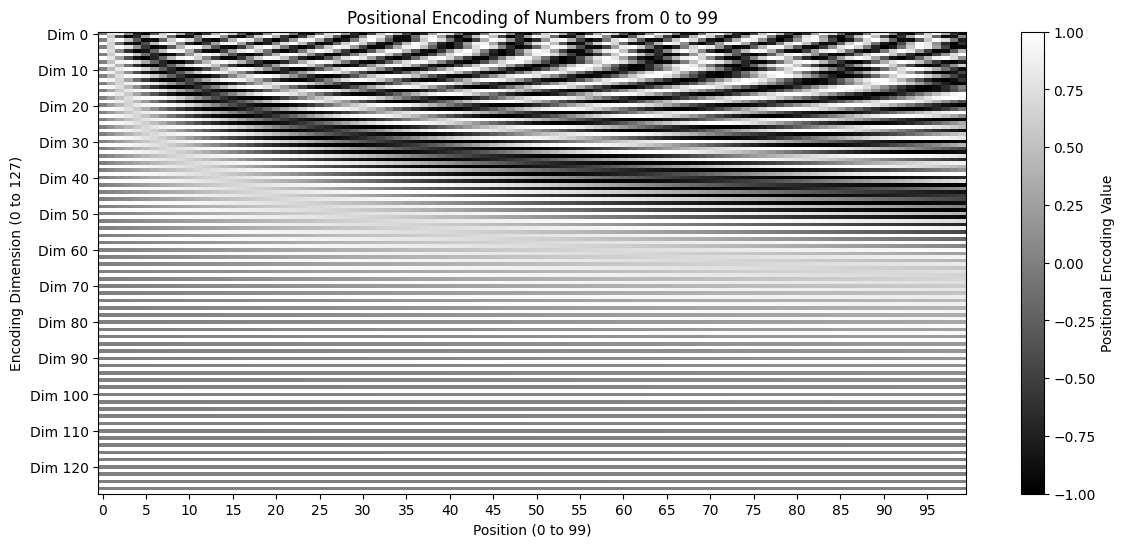

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Extract positional encodings for the first 100 positions and 16 dimensions
positional_encodings = pos_encoding.pe[:,:context_len, :d_model].numpy()
print(positional_encodings.shape)  # Verify shape should be (100, 16)

# Plot the positional encodings using imshow
plt.figure(figsize=(14, 6))
plt.imshow(positional_encodings.T, aspect='auto', cmap='gray', interpolation='nearest')
plt.colorbar(label='Positional Encoding Value')

# Set axis labels and titles
plt.xlabel(f'Position (0 to {context_len-1})')
plt.ylabel(f'Encoding Dimension (0 to {d_model-1})')
plt.title(f'Positional Encoding of Numbers from 0 to {context_len-1}')

# Set x-ticks for positions (adjusted for clarity)
plt.xticks(np.arange(0, pos_encoding.num_range, step=5))

# Set y-ticks for every second encoding dimension, labeled as 'Dim 0', 'Dim 2', etc.
plt.yticks(np.arange(0, d_model, step=10), labels=[f'Dim {i}' for i in range(0, d_model, 10)])

plt.show()

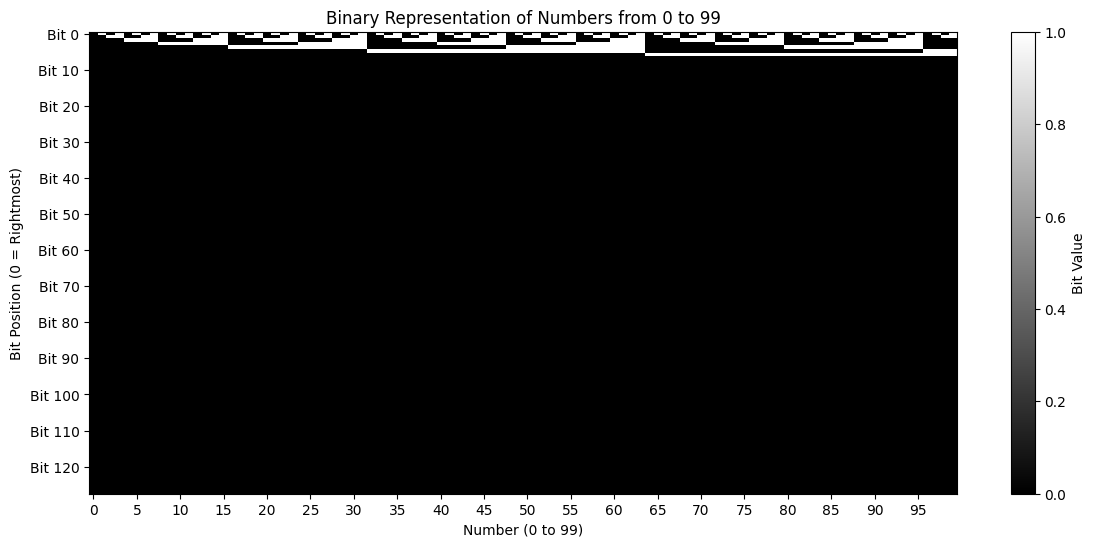

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate binary representation of numbers from 0 to 99 with 20 bits
bit_length = d_model # Number of bits to represent each number (20 bits)
binary_representation = [np.binary_repr(i, width=bit_length) for i in range(context_len)]

# Convert binary strings to a 2D numpy array of integers and reverse the order of bits
binary_matrix = np.array([[int(bit) for bit in bin_str[::-1]] for bin_str in binary_representation])

# Transpose the matrix to have bits on the y-axis (bit position)
binary_matrix = binary_matrix.T

# Plotting the binary matrix in grayscale
plt.figure(figsize=(14, 6))
plt.imshow(binary_matrix, aspect='auto', cmap='gray', interpolation='nearest')
plt.colorbar(label='Bit Value')

# Set axis labels and titles
plt.xlabel('Number (0 to 99)')
plt.ylabel('Bit Position (0 = Rightmost)')
plt.title('Binary Representation of Numbers from 0 to 99')

# Set x-ticks for every 5th number for clarity
plt.xticks(np.arange(0, context_len, step=5))

# Set y-ticks to label every second bit position
plt.yticks(np.arange(0, bit_length, step=10), labels=[f'Bit {i}' for i in range(0, bit_length, 10)])

plt.show()

### 2.3 - Single-Head Self-Attention [2/2]

For single-head self-attention, we will use *scaled dot-product attention* to implement the class `Head`. Recall that for each (embedded) token $x_t$, we extract its query $q_t$, key $k_t$, and value $v_t$ as follows:
$$
\begin{align}
&q_t = W_Q x_t,\\
&k_t = W_K x_t,\\
&v_t = W_V x_t
\end{align}
$$
where $x_t \in \mathbb{R}^{d_{model}}$, $W_Q \in \mathbb{R}^{d_k \times d_{model}}$, $W_K \in \mathbb{R}^{d_k \times d_{model}}$, and $W_V \in \mathbb{R}^{d_v \times d_{model}}$.

Using the query $q_t$ to consult the keys from other tokens, we compute the attention score:
$$
\alpha_{t, s} \propto \frac{q_t \cdot k_s}{\sqrt{d_k}}
$$
Then the refined representation of $x_t$ is given by weighted sum of all vablues $v_s$:
$$
h_t = \sum_{s} \alpha_{t, s} v_s = V \alpha_t
$$
Putting these computations together in matrix form, we have:
$$
\begin{align}
&Q = X W_Q^{\top} \\
&K = X W_K^{\top} \\
&V = X W_V^{\top} \\
&H = \text{softmax}\left(\frac{Q K^{\top}}{\sqrt{d_k}}\right) V
\end{align}
$$
where $X \in \mathbb{R}^{b \times d_{model}}$, $Q \in \mathbb{R}^{b \times d_k}$, $K \in \mathbb{R}^{b \times d_k}$, $V \in \mathbb{R}^{b \times d_v}$, and $H \in \mathbb{R}^{b \times d_v}$ with batch size $b$.

Thus, we implement single-head attention as a class `Head`, which takes `d_model`, `d_k`, `d_v`, and `context_len` as inputs. We store these arguments as attributes and define the three linear transformations using `nn.Linear`.

In the `forward()` method, which takes `x` (a batch of sequences with shape `(batch_size, context_len, d_model)`):
1. Project `x` into queries `Q`, keys `K`, and values `V`.
2. Compute the scaled dot-product attention scores.

Additionally, since we are implementing a **decoder-only** architecture for GPT, we must prevent the model from seeing future tokens. Therefore, `Head` uses **masked** attention. Specifically, we register a `mask` buffer, which is a square matrix with all lower triangular elements (inclusive of the diagonal) as ones and all upper triangular elements as zeros. This `mask` is applied to the attention scores by replacing the upper triangular values with $-inf$.

Finally, we use `F.softmax` to convert the attention scores to probabilities, and compute the weighted sum using $V$ and the probabilities to obtain the `output`, which we return.

**Exercise [2/2]**: Implement the class `Head`.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Head(nn.Module):
    def __init__(self, d_model, d_k, d_v, context_len=100):
        super().__init__()
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.context_len = context_len
        ### Code HERE ### (~ 3 line)

        ### Code HERE ###

        # Register the mask buffer for causal masking
        self.register_buffer("mask", torch.tril(torch.ones(self.context_len, self.context_len)))

    def forward(self, x):
        # x: (batch_size, context_len, d_model)

        # Project input to query, key, and value spaces
        ### Code HERE ### (~ 3 line)

        ### Code HERE ###

        # Compute scaled dot-product attention scores
        ### Code HERE ### (~ 2 line)

        ### Code HERE ###

        # Convert scores to probabilities
        ### Code HERE ### (~ 1 line)

        ### Code HERE ###

        # Weighted sum of values
        ### Code HERE ### (~ 1 line)

        ### Code HERE ###
        return output

In [ ]:
# Test single-head attention
num_heads = 8
d_k = d_v = d_model // num_heads

# Initialize the Head instance
head = Head(d_model=d_model, d_k=d_k, d_v=d_v, context_len=context_len)

# Generate random input tensor (batch_size, context_len, d_model)
x = torch.randn(batch_size, context_len, d_model)

# Pass through the Head layer
output = head(x)

# Check output shape and print a portion of it
print("Output shape:", output.shape)  # Expected shape: (batch_size, context_len, d_v)
print("Output (first example, first few tokens):", output[0, :5, :])  # Print a small part of the output

Output shape: torch.Size([64, 100, 16])
Output (first example, first few tokens): tensor([[-0.1552, -0.7164,  0.5334, -0.2637, -0.2445, -0.1583, -0.0406, -0.6888,
         -0.3234,  0.0677, -0.2842, -0.4438,  0.2728,  0.6670,  0.4455, -0.1847],
        [-0.1715, -0.4832,  0.1284,  0.1091, -0.2555, -0.0278,  0.6794, -0.4714,
         -0.1484, -0.3501, -0.4977,  0.5210,  0.2166,  0.7438,  0.3668,  0.2343],
        [-0.0309, -0.3571,  0.3763,  0.3872, -0.3312, -0.0615,  0.7272, -0.6818,
         -0.1749, -0.4289, -0.1050,  0.4689,  0.1894,  0.8842, -0.0039,  0.2263],
        [-0.1248, -0.4338,  0.2829,  0.2325, -0.3218, -0.1404,  0.6324, -0.7462,
         -0.2006, -0.3998, -0.0773,  0.2265,  0.0059,  0.7160,  0.0160,  0.0440],
        [-0.0532, -0.3546,  0.3370,  0.2817, -0.2464, -0.2829,  0.6830, -0.6866,
         -0.0327, -0.3242,  0.0478,  0.2663, -0.0847,  0.5655,  0.2315,  0.0373]],
       grad_fn=<SliceBackward0>)


### 2.4 - Multi-Head Attention [1/1]
The next step is to implement multi-head attention. In the original paper, the class takes `d_model` and `num_heads` as inputs. For each head, it uses a head size of $d_k = d_v = d_{model} // \text{num_heads}$.

Recall that in the original paper, the query, key, and value matrices are unified, and each head has its own independent projection matrices $P^Q_{h}$, $P^K_{h}$, and $P^V_{h}$. Therefore, each head’s query, key, and value can be derived as:
$$
Q_h = Q P^Q_{h} = X W_Q P^Q_{h} = X W_h^{Q},
\quad \text{where} \quad
W_h^{Q} = W_Q P^Q_{h}
$$
Thus, implementing multi-head attention is equivalent to maintaining a list of `heads` using an `nn.ModuleList` of `Head` instances.

In the `forward()` method:
1. Each `head` will compute its refined representation of the input sequence.
2. The results from each head are concatenated into `head_outputs`.
3. A final linear transformation is applied to aggregate all heads into a single refined representation, `output`, which is then returned.

**Exercise [1/1]**: Implement the class `MultiHeadAttention`.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads=8, context_len=100):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        ### Code HERE ### (~ 3-4 line)

        ### Code HERE ###

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)

        # Apply each head in parallel
        ### Code HERE ### (~ 1 line)

        ### Code HERE ###

        # Final linear transformation
        ### Code HERE ### (~ 1 line)

        ### Code HERE ###
        return output

In [ ]:
# Test multi-head attention
multi_head_attn = MultiHeadAttention(d_model=d_model, num_heads=num_heads, context_len=context_len)
output = multi_head_attn(src_embedded)

print("Output shape:", output.shape)  # Expected shape: (batch_size, context_len, d_model)
print("Output (first example, first few tokens):", output[0, :5, :10])  # Print a small part of the output

Output shape: torch.Size([64, 100, 128])
Output (first example, first few tokens): tensor([[ 0.8811, -0.0619, -0.0464,  0.7163,  0.0241,  0.7176, -0.2537,  0.1968,
         -0.5338,  0.5854],
        [ 0.5930,  0.2286, -0.3235,  0.5562, -0.4968,  0.4168, -0.2625, -0.3588,
         -0.3436,  0.7633],
        [ 0.4504,  0.1661, -0.4506,  0.3866, -0.4574,  0.5318, -0.2453, -0.3845,
         -0.4837,  0.4788],
        [ 0.3769,  0.1890, -0.4161,  0.3442, -0.4474,  0.5191, -0.3689, -0.3171,
         -0.5995,  0.5999],
        [ 0.2558, -0.0601, -0.4346,  0.2212, -0.4455,  0.3610, -0.5656, -0.3113,
         -0.3480,  0.4920]], grad_fn=<SliceBackward0>)


### 2.5 - Feed-Forward Network [1/1]

Recall that the attention mechanism refines representations by taking a weighted sum of tokens based on their relevance to each other. However, this weighted sum only captures *linear* relationships. To enhance the model’s capacity to learn *nonlinear* relationships, each sublayer also includes a two-layer feed-forward network (FFN) with a non-linear activation, such as ReLU or GELU.

In the original Transformer paper, ReLU was used as the activation function, while GPT uses GELU. The FFN layer first transforms the input to a higher dimension `d_ff` in the first layer and then projects it back to `d_model` in the second layer.

**Exercise [1/1]**: Implement the class `FFN`.

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super().__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        ### Code HERE ### (~ 2-3 line)

        ### Code HERE ###

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        return self.ffn(x)

In [ ]:
# Test ffc
d_ff = 256
ffn = FeedForward(d_model=d_model, d_ff=d_ff)
output = ffn(output)

print("Output shape:", output.shape)  # Expected shape: (batch_size, context_len, d_model)
print("Output (first example, first few tokens):", output[0, :5, :10])  # Print a small part of the output

Output shape: torch.Size([64, 100, 128])
Output (first example, first few tokens): tensor([[-0.0403,  0.0068, -0.0345, -0.0319, -0.0303, -0.0589, -0.0127,  0.0374,
          0.0008,  0.0686],
        [-0.0459,  0.0127, -0.0363, -0.0298, -0.0354, -0.0572, -0.0086,  0.0334,
         -0.0004,  0.0566],
        [-0.0508,  0.0141, -0.0399, -0.0309, -0.0393, -0.0506, -0.0105,  0.0392,
         -0.0089,  0.0566],
        [-0.0516,  0.0120, -0.0393, -0.0261, -0.0347, -0.0554, -0.0102,  0.0402,
         -0.0070,  0.0572],
        [-0.0515,  0.0232, -0.0421, -0.0250, -0.0405, -0.0538, -0.0106,  0.0398,
         -0.0041,  0.0538]], grad_fn=<SliceBackward0>)


### 2.6 - Transformer Decoder Layer [1/1]

In this step, we implement a Transformer decoder layer that combines multi-head self-attention with a feed-forward network (FFN).

In the original Transformer, a *post-norm* approach was used, where layer normalization is applied after the attention and FFN layers, following a skip connection. This approach helps to stabilize training by normalizing the outputs.

However, GPT-2 uses a *pre-norm* approach, where layer normalization is applied to the input before the attention or FFN layers, followed by a skip connection. This *pre-norm* setup has become more popular in large language models (LLMs) as it improves stability when training deeper Transformer architectures.

**Exercise [1/1]**: Implement the `TransformerDecoderLayer` class.

In [ ]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads=8, d_ff=2048, context_len=100):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.context_len = context_len
        ### Code HERE ### (~ 4-5 line)

        ### Code HERE ###

    def forward(self, x):
        # Multi-head attention with residual connection and normalization
        ### Code HERE ### (~ 1 line)

        ### Code HERE ###

        # Feed-forward network with residual connection and normalization
        ### Code HERE ### (~ 1 line)

        ### Code HERE ###
        return x

In [ ]:
# Test transformer decoder layer
transformer_decoder_layer = TransformerDecoderLayer(d_model=d_model, num_heads=num_heads, d_ff=d_ff, context_len=context_len)
output = transformer_decoder_layer(src_embedded)

print("Output shape:", output.shape)
print("Output (first example, first few tokens):", output[0, :5, :10])  # Print a small part of the output

Output shape: torch.Size([64, 100, 128])
Output (first example, first few tokens): tensor([[-0.7102,  3.1978, -0.1540,  0.6231, -0.7459,  0.8656, -0.0754,  2.0435,
          0.8632, -0.9143],
        [ 1.5981,  0.0970,  1.6640, -0.1924,  0.9681, -1.7205, -0.7827,  2.2688,
          0.8200,  2.9261],
        [ 3.5588, -1.8806,  1.0660,  1.3493,  0.1578, -1.1865,  1.2189,  0.4269,
         -0.5003,  1.5890],
        [ 0.9273, -1.8560,  0.7325, -3.1479,  1.1474, -1.8684,  0.2978, -0.1549,
          0.5064,  0.6918],
        [-2.2407, -1.4595, -2.0831, -0.8397, -1.7269, -1.2521,  0.0210,  0.8799,
          2.1966, -2.5654]], grad_fn=<SliceBackward0>)


### 2.7 - Stack Decoder Layers [1/1]

In this step, we implement the complete decoder structure of a Transformer by stacking multiple `TransformerDecoderLayer` instances. This allows the model to refine its representations through multiple layers of self-attention and FFN.

1. **Initialize Layers**: The class should take `d_model`, `num_heads`, `dim_ffn`, `num_layers`, and `context_len` as inputs, which specify the depth and configuration of each decoder layer.
2. **Stack Layers**: Use `nn.ModuleList` to stack `num_layers` instances of `TransformerDecoderLayer`.
3. **Forward Pass**: In the `forward()` method, pass the input sequentially through each decoder layer to progressively refine the representations.

By stacking layers, we enable the model to capture increasingly complex patterns in the input sequences.

**Exercise [1/1]**: Implement the class `TransformerDecoder`.

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, d_model, num_heads=8, d_ff=2048, context_len=100, num_layers=6):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.context_len = context_len
        self.num_layers = num_layers
        ### Code HERE ### (~ 2 line)

        ### Code HERE ###

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
# Test transformer decoder with multiple layers
num_layers = 2
transformer_decoder = TransformerDecoder(d_model=d_model, num_heads=num_heads, d_ff=d_ff, context_len=context_len, num_layers=num_layers)
output = transformer_decoder(src_embedded)

print("Output shape:", output.shape)
print("Output (first example, first few tokens):", output[0, :5, :10])  # Print a small part of the output

Output shape: torch.Size([64, 100, 128])
Output (first example, first few tokens): tensor([[-0.8244,  2.8517,  0.3345,  0.9547, -1.0161,  1.3835,  0.8382,  2.5565,
          0.7454, -0.4393],
        [ 1.4540,  0.6233,  2.3760, -0.4171,  1.3413, -0.9960, -0.8449,  2.7310,
          0.0853,  3.3066],
        [ 3.0457, -1.3023,  1.7763,  1.5710, -0.0652, -0.8525,  1.1310,  1.1835,
         -0.8016,  1.1735],
        [ 0.6006, -1.4312,  0.9813, -2.6448,  0.8963, -1.2067,  1.1037, -0.0506,
         -0.2044,  0.0165],
        [-1.8875, -0.9837, -1.9365, -1.1464, -1.7077, -0.7837,  0.2769,  1.2028,
          1.2780, -2.9112]], grad_fn=<SliceBackward0>)


### 2.8 - Complete GPT Model [3/3]
Now, all the compoentes are impelemdn for GPT. so we can put everything together to buld the transformer-decoder-only GPT by following the following structure:
`word_embedding -> positional_encoding -> decoder -> ouptut_layer`
Note that the output in the `forward()` will return the `logits` that is the result after the final linear layer but before the `softmax`. By returning the `logits` rather than the probabilities, it facilits traiining using cross-entropy loss and also simplify the `generate()` method.

To generate text, we will also impelemnt a `generate()` method that takes a `start_tokens` and `max_new_tokens` to genereate the result. Then we continuously predict next token by using the already `generated` text starting with `generated=start_tokens`. for each time, we call the `forward()` method to get `logits`. Then we obtain the `probs` by using the `softmax`. In the previous assingment, we predict the next token by taking the highest probability. Now, we use another method by stochastically sample the next token using the computed `probs`. You would note that `torch.multinomial()` is useful to randomly sample the `next_token`. Then we concate the `next_token` to the already `generated`. Once reaching the end of `max_new_tokens`, we return the `generated` tokens.

**Note**: in GPT `generate()` method, we have an additional argument `temperature` that is used to refine the `logits` by taking `logits = logits / temperature`.

The temperature in language generation is a way to control the randomness of predictions by scaling the logits before applying softmax. It’s true that every logit is divided by the same constant, but the effect on the softmax output (probabilities) can be significant, especially for larger temperature values.

Effect of Temperature on Logits
1. When Temperature = 1.0:
 - The logits are unchanged, so softmax operates as usual.
2. When Temperature < 1.0 (e.g., 0.5):
 - Dividing by a small temperature “sharpens” the logits. This increases the difference between high and low logits.
 - The result: higher probabilities for the most likely tokens and lower probabilities for the rest. This makes the model more deterministic, as it’s more likely to choose the highest probability token.
3. When Temperature > 1.0 (e.g., 1.5):
 - Dividing by a large temperature “flattens” the logits, decreasing the difference between high and low logits.
 - The result: more even probabilities, where even less likely tokens have a higher chance of being sampled. This increases randomness and diversity but can lead to less coherent output.

**Exercise [2/2]**: Implement `GPTModel`


### 2.8 - Complete GPT Model [3/3]

Now that all the components are implemented, we can put everything together to build the Transformer-decoder-only GPT model. The structure of the model will be as follows:

`word_embedding -> positional_encoding -> decoder -> output_layer`

**Implementation Details**:
- In the `forward()` method, the output will be the `logits`, which are obtained from the final linear layer (output layer) before applying `softmax`. Returning `logits` rather than probabilities facilitates training with cross-entropy loss and simplifies the `generate()` method.

**Text Generation**:
To generate text, we will implement a `generate()` method that takes `start_tokens` and `max_new_tokens` as inputs to generate text of the desired length. The process is as follows:
1. Initialize `generated` as `start_tokens`.
2. For each step:
   - Call the `forward()` method on `generated` to obtain `logits`.
   - Use `softmax` to convert `logits` to probabilities (`probs`).
   - Instead of choosing the highest probability token, we stochastically sample the next token based on the probabilities using `torch.multinomial()`. This approach provides more diverse and creative outputs.
   - Concatenate the `next_token` to `generated`.
3. Stop generating tokens once `max_new_tokens` is reached, and return the `generated` sequence.

**Temperature in Generation**:
In the `generate()` method, an additional parameter `temperature` controls the randomness of predictions by scaling the logits before softmax. While dividing by the same constant might seem to have no effect, it can significantly impact the output probabilities depending on the temperature value:
- **Temperature = 1.0**: Logits remain unchanged, and softmax behaves normally.
- **Temperature < 1.0** (e.g., 0.5): Dividing by a smaller temperature "sharpens" the logits, increasing the difference between high and low values. This makes the model more deterministic, as it prefers the most likely tokens.
- **Temperature > 1.0** (e.g., 1.5): Dividing by a larger temperature "flattens" the logits, reducing the difference between values. This gives even less likely tokens a higher chance, increasing randomness and output diversity but sometimes decreasing coherence.

In summary:
- Lower temperature values (e.g., 0.5) yield more focused, coherent text by reducing the randomness of token selection.
- Higher temperature values (e.g., 1.5) create more diverse and unexpected outputs, though potentially at the cost of coherence.

**Exercise [2/2]**: Implement the `GPTModel` class.

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads=8, d_ff=2048, context_len=100, num_layers=6):
        super().__init__()
        # Store hyper-params
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.context_len = context_len
        self.num_layers = num_layers

        # Define network achitecture
        ### Code HERE ### (~ 4 line)

        ### Code HERE ###

    def forward(self, x):
        # x: (batch_size, context_len)
        ### Code HERE ### (~ 3 line)

        ### Code HERE ###
        logits = self.fc_out(x) # (batch_size, context_len, vocab_size)
        return logits

    @torch.no_grad()  # Prevents gradient computation during generation
    def generate(self, start_tokens, max_new_tokens=50, temperature=1.0):
        self.eval()
        # start_tokens: initial tokens to begin generation, shape (1, context_len) or similar
        generated = start_tokens  # Shape: (1, current_seq_len)

        for _ in range(max_new_tokens):
            ### Code HERE ### (~ 3 line)

            ### Code HERE ###

            # Scale logits by temperature (controls randomness)
            logits = logits / temperature

            ### Code HERE ### (~ 2 line)

            ### Code HERE ###

            # Append the generated token to the sequence
            generated = torch.cat((generated, next_token), dim=1)  # Update sequence

        return generated

In [ ]:
# Test GPT-2 implemented by decoder only
gpt = GPTModel(vocab_size, d_model=d_model, num_heads=num_heads, d_ff=d_ff, context_len=context_len, num_layers=num_layers)
output = gpt(src)

print("Output shape:", output.shape)  # Expected shape: (batch_size, context_len, vocab_size)
print("Output (first example, first few tokens):", output[0, :5, :10])  # Print a small part of the output

Output shape: torch.Size([64, 100, 65])
Output (first example, first few tokens): tensor([[-1.7438,  0.3521, -0.8395,  0.0834,  0.1877,  0.8734,  0.2217,  0.6290,
          0.4441,  0.5069],
        [-0.4328,  0.3635, -0.0228,  0.6242,  1.2791, -0.0853,  0.6004,  1.3853,
         -0.2307,  0.3153],
        [-0.8086, -0.3301, -0.1786,  0.2915,  0.3923,  0.0227, -0.4083,  0.0268,
          0.6701,  1.3072],
        [-0.9505, -0.1835, -1.2621, -0.4657,  0.8987,  0.6707, -0.6329,  0.5898,
         -0.6596,  0.7973],
        [-0.0678, -0.1395, -0.5094, -0.6740,  0.7487,  0.1021, -0.3977, -0.5235,
         -0.6727,  0.5510]], grad_fn=<SliceBackward0>)


## 3 - Training

In [ ]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for src, tgt in dataloader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = model(src)
        loss = criterion(output.view(-1, output.size(-1)), tgt.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src)
            loss = criterion(output.view(-1, output.size(-1)), tgt.view(-1))
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
# set seed for reproduce
torch.manual_seed(1)
# check if cuda avaialbe, if so use cuda for device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda


In [ ]:
# define hyper-params
d_model = 128
num_heads = 8
d_ff = 256
num_layers = 2
print(f"data hyper-paras: vocab_size: {vocab_size}, context_len: {context_len}, batch_size: {batch_size}")
print(f"model hyper-paras: d_model: {d_model}, num_heads: {num_heads}, d_ff: {d_ff}, num_layers: {num_layers}")

gpt = GPTModel(vocab_size, d_model=d_model, num_heads=num_heads, d_ff=d_ff, context_len=context_len, num_layers=num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gpt.parameters(), lr=0.01)

train_losses = []
val_losses = []
max_iter = 10
for epoch in range(max_iter):
    train_loss = train(gpt, train_dataloader, criterion, optimizer, device)
    val_loss = evaluate(gpt, val_dataloader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{max_iter}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

data hyper-paras: vocab_size: 65, context_len: 100, batch_size: 64
model hyper-paras: d_model: 128, num_heads: 8, d_ff: 256, num_layers: 2
Epoch 1/10, Train Loss: 1.3998, Val Loss: 1.3138
Epoch 2/10, Train Loss: 1.2931, Val Loss: 1.2898
Epoch 3/10, Train Loss: 1.2718, Val Loss: 1.2613
Epoch 4/10, Train Loss: 1.2609, Val Loss: 1.2566
Epoch 5/10, Train Loss: 1.2535, Val Loss: 1.2536
Epoch 6/10, Train Loss: 1.2479, Val Loss: 1.2479
Epoch 7/10, Train Loss: 1.2438, Val Loss: 1.2467
Epoch 8/10, Train Loss: 1.2402, Val Loss: 1.2344
Epoch 9/10, Train Loss: 1.2371, Val Loss: 1.2369
Epoch 10/10, Train Loss: 1.2346, Val Loss: 1.2372


## 4 - Generation

In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(gpt.generate(context, max_new_tokens=2000)[0].tolist()))



JULIET:
At saint before, sir; for Romeo, hath done
Would call upon my light!
Are or then both and find Keeper.
Srik! it is stinted awhile, untimeent,
Could man impose bed, to do I am please;
If you be so state,
To line and beautified with Coriolanus
Adder glight: then I'll report of this doom.

CORIOLANUS:
Come, sir, come from from his tongue face,
To fight of the king 'Wedness! Well, sir?

MENENIUS:
Her wife write to crave;
Thou hast displeady her tent here crown;
And will but entreatnes are but a Juliet,
Though our lawsted.

LEONTES:
Call the tleness of England!
The mark of Olgher? My railitler koes,
Prodiging Rutland night,
So by gone the chamber to sin! What at o sudden?
For me fast to tell thee, love my very;
For thou! I am speak an unswaming the oath of blatter,
Or deny to crave with true blinds Clifford forget,
Castin, so we did again, I'll femal do beheld
Stand for which they coister, 'tis from men
To wait with this court weeping.
I no woes report thou offence mouth art
May u